# LAB 2 — Body Fat Prediction (Python notebook mapping to the KNIME workflow)

This notebook mirrors the KNIME workflow in your LAB 2 overview:

1) **Data Preparation**  
- Read the BodyFat dataset from CSV  
- Remove **Density** (to simulate missing real-world measurements)  
- Split **Train/Test = 80/20**

2) **Baseline Regression Model**  
- Train **Linear Regression** on Train  
- Evaluate on Test (RMSE, R²) + scatter plot

3) **Regression + Feature Selection (Wrapper)**
- Split **Dev/Test = 80/20**, then split Dev into **Train/Validation**
- Fit **Normalizer (StandardScaler)** on Train only; apply to Validation and Test  
- Wrapper feature selection: evaluate feature subsets by **Validation RMSE** (minimize)
- Retrain final model with selected features, evaluate once on Test



## 0) Setup

In [1]:
import os
import numpy as np
import pandas as pd
import sys

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

IN_COLAB = "google.colab" in sys.modules
CSV_NAME = "bodyfat.csv"


def resolve_data_dir():
    candidate_dirs = [
        ".",                  # same folder as notebook
        "/content",           # Colab root
    ]

    for base in candidate_dirs:
        csv_candidate = os.path.join(base, CSV_NAME)
        if os.path.exists(csv_candidate):
            print(f"Using data directory: {os.path.abspath(base)}")
            return base

    raise FileNotFoundError(
        "Could not find 'diabetes.csv'. Please place it next to the notebook "
    )


DATA_DIR = resolve_data_dir()
DATA_PATH = os.path.join(DATA_DIR, CSV_NAME)

Using data directory: /Users/theerapatkangsilalai/Documents/GitHub/digitalhealth-ai2025/code/Week02_ML


## 1) Load data and remove `Density`

In [2]:
df = pd.read_csv(DATA_PATH)

print("Columns:", list(df.columns))
display(df.head())

density_cols = [c for c in df.columns if c.lower() == "density"]
if density_cols:
    df = df.drop(columns=density_cols)
    print(f"Removed Density column(s): {density_cols}")
else:
    print("No 'Density' column found; nothing removed.")


Columns: ['Density', 'BodyFat', 'Age', 'Weight', 'Height', 'Neck', 'Chest', 'Abdomen', 'Hip', 'Thigh', 'Knee', 'Ankle', 'Biceps', 'Forearm', 'Wrist']


,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


Removed Density column(s): ['Density']


## 2) Train/Test split (80/20)

In [3]:
# Target column
target_candidates = [c for c in df.columns if c.lower() in ("bodyfat", "body_fat", "body fat")]
if not target_candidates:
    raise ValueError("Cannot find target column. Expected something like 'BodyFat'.")
TARGET = target_candidates[0]

X = df.drop(columns=[TARGET])
y = df[TARGET]

# 80/20 split (match KNIME Table Partitioner concept)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (201, 13) Test shape: (51, 13)


## 3) Baseline Linear Regression (no feature selection)

Baseline RMSE: 4.2403
Baseline R^2 : 0.6135


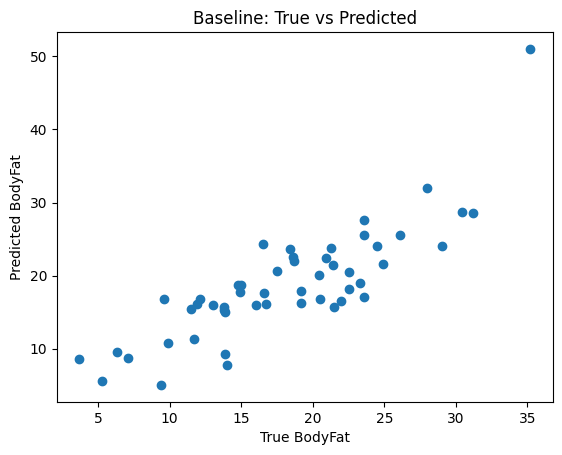

In [4]:
baseline = LinearRegression()
baseline.fit(X_train, y_train)

y_pred = baseline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Baseline RMSE: {rmse:.4f}")
print(f"Baseline R^2 : {r2:.4f}")

plt.figure()
plt.scatter(y_test, y_pred)
plt.xlabel("True BodyFat")
plt.ylabel("Predicted BodyFat")
plt.title("Baseline: True vs Predicted")
plt.show()


## 4) Feature Selection workflow: Train/Validation/Test + Normalization

In [5]:

X_dev, X_test, y_dev, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

X_trian, X_val, y_train, y_val = train_test_split(
    X_dev, y_dev, test_size=0.25, random_state=42
)

print("Train:", X_trian.shape, "Val:", X_val.shape, "Test:", X_test.shape)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_trian)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

feature_names = list(X.columns)

Train: (150, 13) Val: (51, 13) Test: (51, 13)


## 5) Wrapper feature selection by Validation RMSE (minimize)

In KNIME, **Feature Selection Loop Start/End** iterates over candidate feature sets and uses a **single numeric score**
(e.g., RMSE from Numeric Scorer) to pick the best subset.

Below, we do an **exhaustive** subset search (feasible for small feature counts).


In [6]:
from itertools import combinations

def eval_subset(cols_idx):
    model = LinearRegression()
    model.fit(X_train_s[:, cols_idx], y_train)
    pred = model.predict(X_val_s[:, cols_idx])
    return float(np.sqrt(mean_squared_error(y_val, pred)))

n_features = X_train_s.shape[1]

best_rmse = float("inf")
best_subset = None

for k in range(1, n_features + 1):
    for cols in combinations(range(n_features), k):
        rmse_k = eval_subset(cols)
        if rmse_k < best_rmse:
            best_rmse = rmse_k
            best_subset = cols

selected_features = [feature_names[i] for i in best_subset]
print("Best Validation RMSE:", round(best_rmse, 4))
print("Selected features (count={}):".format(len(selected_features)))
print(selected_features)

Best Validation RMSE: 4.1693
Selected features (count=9):
['Age', 'Weight', 'Height', 'Abdomen', 'Hip', 'Ankle', 'Biceps', 'Forearm', 'Wrist']


## 6) Final model: retrain using selected features, evaluate on Test once

Final (selected features) Test RMSE: 4.2764
Final (selected features) Test R^2 : 0.6069


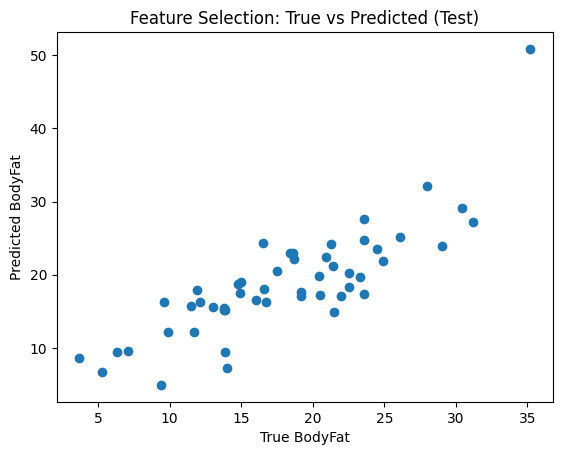

In [12]:
X_train_val_s = np.vstack([X_train_s, X_val_s])
y_train_val = pd.concat([y_train, y_val], axis=0)

final_model = LinearRegression()
final_model.fit(X_trval_s[:, best_subset], y_trval)

test_pred = final_model.predict(X_test_s[:, best_subset])
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
test_r2 = r2_score(y_test, test_pred)

print(f"Final (selected features) Test RMSE: {test_rmse:.4f}")
print(f"Final (selected features) Test R^2 : {test_r2:.4f}")

plt.figure()
plt.scatter(y_test, test_pred)
plt.xlabel("True BodyFat")
plt.ylabel("Predicted BodyFat")
plt.title("Feature Selection: True vs Predicted (Test)")
plt.show()

## 7) Summary table: Baseline vs Feature Selection

In [11]:
summary = pd.DataFrame({
    "Model": ["Baseline (Train/Test 80/20)", "Wrapper FS (Train/Val/Test + scaler)"],
    "RMSE": [rmse, test_rmse],
    "R2": [r2, test_r2],
})
summary


,Model,RMSE,R2
0,Baseline (Train/Test 80/20),4.240279,0.613484
1,Wrapper FS (Train/Val/Test + scaler),4.276404,0.606870
